In [119]:
from graphviz import Digraph
import math
import numpy as np
import matplotlib.pyplot as plt

In [120]:
class Value:
    def __init__(self, data, prev=(), op='', label=''):
        self.grad = 0

        if hasattr(data, 'data'):
            self.data = data.data
            self._prev = data.prev
            self._op = data.op
        else:
            self.data = data
            self._prev = set(prev)
            self._op = op

        self._label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self, label=None):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        return Value(t, (self,), 'tanh', label=label or f'tanh {self.label}')

    @property
    def label(self):
        if not self._label and self._prev:
            return f"({[n.label for n in self._prev]})"
        return self._label

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op


In [121]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            dot.node(name = uid + n.op, label = n.op)
            dot.edge(uid + n.op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

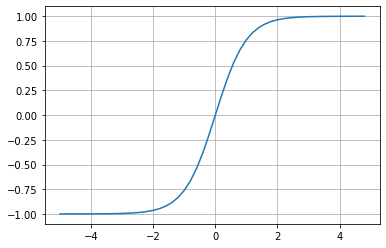

In [122]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [123]:
x1 = Value(2., label='x1') # input
x2 = Value(0., label='x2') # input
w1 = Value(-3., label='w1') # weight
w2 = Value(1., label='w2') # weight
b = Value(6.7, label='b') # bias
x1w1 = Value(x1 * w1, label='x1*w1')
x2w2 = Value(x2 * w2, label='x2*w2')
x1w1x2w2 = Value(x1w1 + x2w2, label='x1*w1 + x2*w2')
n = Value(x1w1x2w2 + b, label='n')
n.data

0.7000000000000002

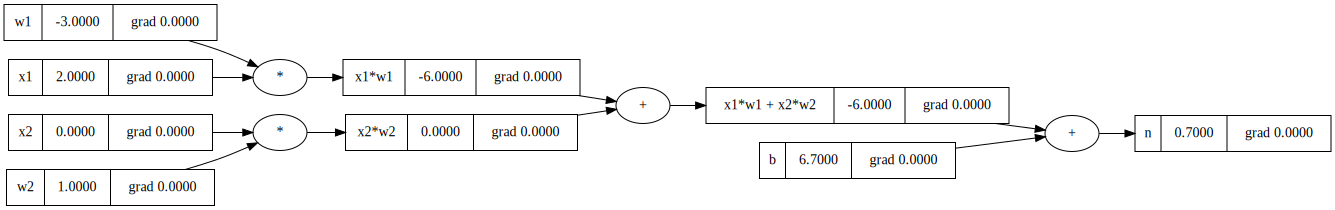

In [124]:
draw_dot(n)

In [125]:
o = n.tanh(label='o')

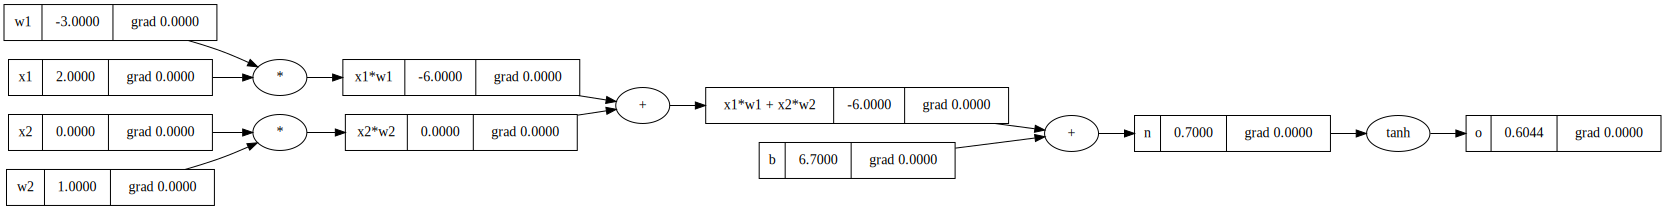

In [126]:
draw_dot(o)

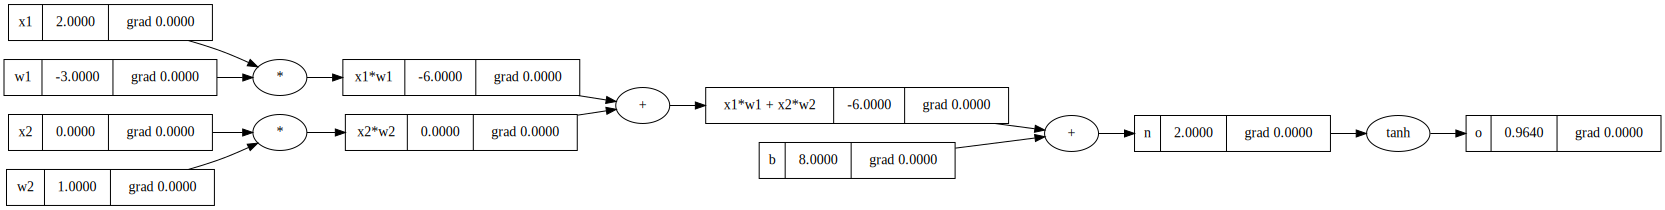

In [127]:
x1 = Value(2., label='x1') # input
x2 = Value(0., label='x2') # input
w1 = Value(-3., label='w1') # weight
w2 = Value(1., label='w2') # weight
b = Value(8, label='b') # bias, since this one will get n to be 2., tanh will get it closer (squashed) to 1
x1w1 = Value(x1 * w1, label='x1*w1')
x2w2 = Value(x2 * w2, label='x2*w2')
x1w1x2w2 = Value(x1w1 + x2w2, label='x1*w1 + x2*w2')
n = Value(x1w1x2w2 + b, label='n')
o = n.tanh(label='o')
draw_dot(o)

In [128]:
x1 = Value(2., label='x1') # input
x2 = Value(0., label='x2') # input
w1 = Value(-3., label='w1') # weight
w2 = Value(1., label='w2') # weight
b = Value(6.88137, label='b') # bias, since this one will get n to be 2., tanh will get it closer (squashed) to 1
x1w1 = Value(x1 * w1, label='x1*w1')
x2w2 = Value(x2 * w2, label='x2*w2')
x1w1x2w2 = Value(x1w1 + x2w2, label='x1*w1 + x2*w2')
n = Value(x1w1x2w2 + b, label='n')
o = n.tanh(label='o')

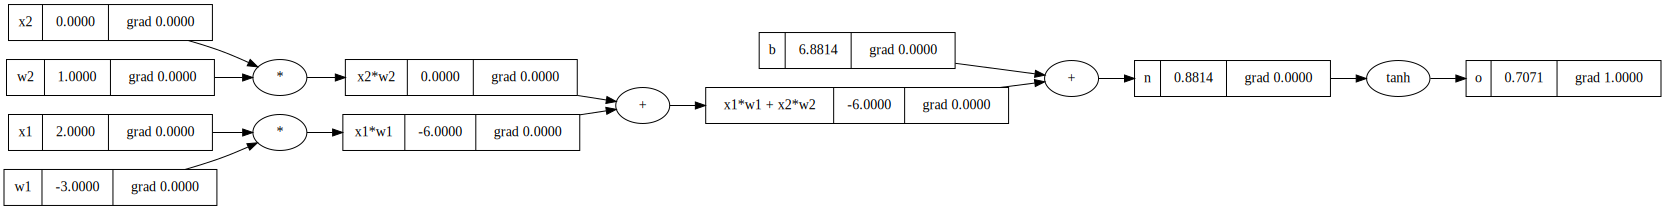

In [129]:
o.grad = 1
draw_dot(o)

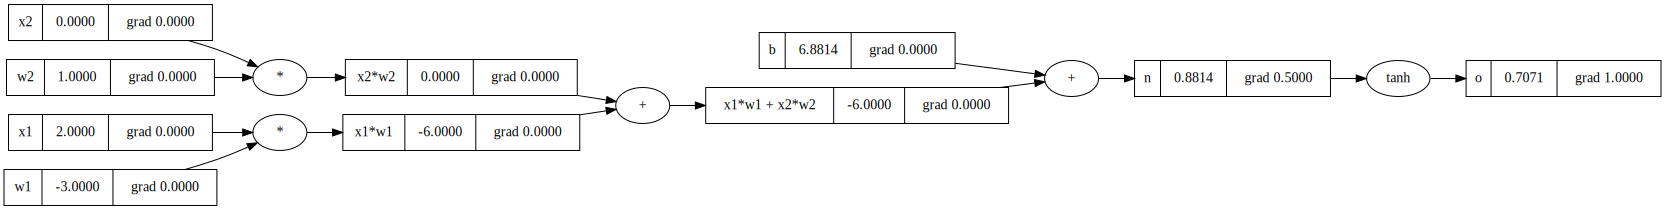

In [130]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**n
n.grad = 1 - o.data**2
draw_dot(o)

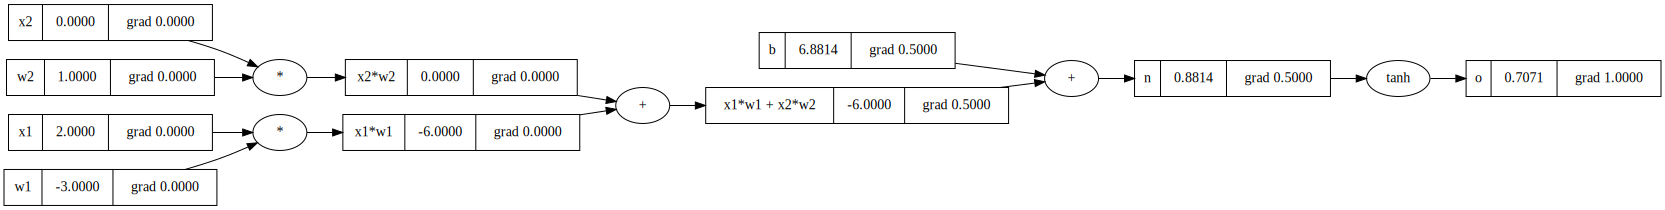

In [131]:
x1w1x2w2.grad = n.grad
b.grad = n.grad
draw_dot(o)

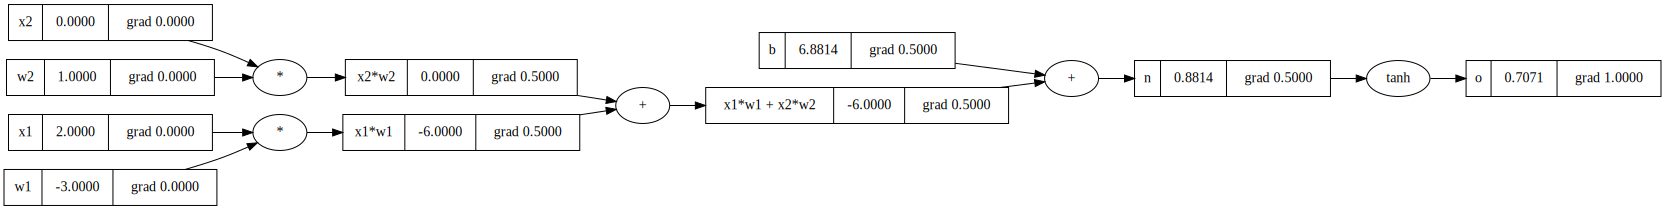

In [132]:
x1w1.grad = n.grad
x2w2.grad = n.grad
draw_dot(o)

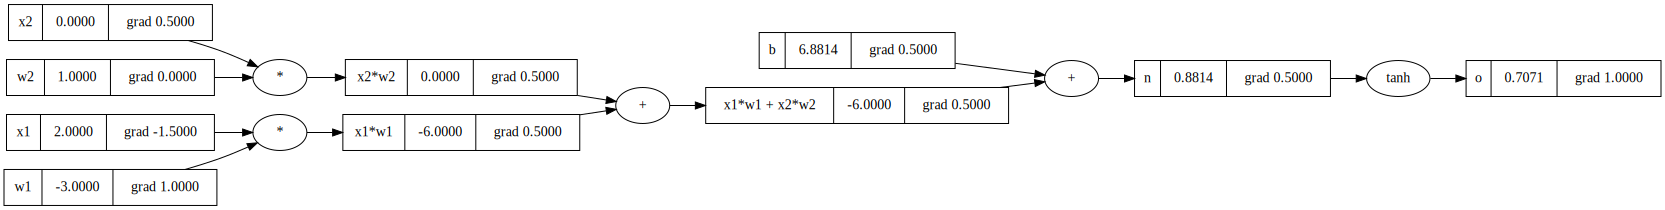

In [133]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
draw_dot(o)